In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

from pylab import rcParams
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed

seed(1)
tf.random.set_seed(2)
SEED = 123
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [2]:
df = pd.read_csv("rare_event_data.csv")

In [3]:
sign = lambda x: (1, -1)[x < 0]

In [4]:
def curve_shift(df, shift_by):
    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    df = df.drop(df[df[labelcol] == 1].index)
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    df.loc[df[labelcol] > 0, labelcol] = 1
    return df

In [5]:
df = curve_shift(df, shift_by = -2)

In [6]:
df = df.drop(['time', 'x28', 'x61'], axis=1)

In [7]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [8]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

In [9]:
scaler = StandardScaler().fit(df_train_0_x)

In [10]:
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))
df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [11]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1]
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

In [12]:
input_layer = Input(shape=(input_dim, ))

In [13]:
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)

In [14]:
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)

In [15]:
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [16]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [17]:
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

In [18]:
tb = TensorBoard(log_dir='logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

In [19]:
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 11541 samples, validate on 2883 samples
Epoch 1/200
11541/11541 [==============================] - 2s 168us/sample - loss: 0.8830 - accuracy: 0.0472 - val_loss: 0.6903 - val_accuracy: 0.0493
Epoch 2/200
11541/11541 [==============================] - 0s 43us/sample - loss: 0.5579 - accuracy: 0.1017 - val_loss: 0.4753 - val_accuracy: 0.1394
Epoch 3/200
11541/11541 [==============================] - 1s 54us/sample - loss: 0.4219 - accuracy: 0.1754 - val_loss: 0.3875 - val_accuracy: 0.2099
Epoch 4/200
11541/11541 [==============================] - 1s 47us/sample - loss: 0.3509 - accuracy: 0.2406 - val_loss: 0.3317 - val_accuracy: 0.2747
Epoch 5/200
11541/11541 [==============================] - 0s 42us/sample - loss: 0.3095 - accuracy: 0.3051 - val_loss: 0.3015 - val_accuracy: 0.3271
Epoch 6/200
11541/11541 [==============================] - 0s 42us/sample - loss: 0.2845 - accuracy: 0.3434 - val_loss: 0.2796 - val_accuracy: 0.3639
Epoch 7/200
11541/11541 [=========================

Epoch 55/200
11541/11541 [==============================] - 1s 45us/sample - loss: 0.1247 - accuracy: 0.5701 - val_loss: 0.1283 - val_accuracy: 0.5536
Epoch 56/200
11541/11541 [==============================] - 0s 34us/sample - loss: 0.1240 - accuracy: 0.5655 - val_loss: 0.1284 - val_accuracy: 0.5470
Epoch 57/200
11541/11541 [==============================] - 0s 42us/sample - loss: 0.1234 - accuracy: 0.5676 - val_loss: 0.1273 - val_accuracy: 0.5650
Epoch 58/200
11541/11541 [==============================] - 0s 40us/sample - loss: 0.1229 - accuracy: 0.5701 - val_loss: 0.1269 - val_accuracy: 0.5536
Epoch 59/200
11541/11541 [==============================] - 0s 41us/sample - loss: 0.1223 - accuracy: 0.5689 - val_loss: 0.1264 - val_accuracy: 0.5591
Epoch 60/200
11541/11541 [==============================] - 0s 41us/sample - loss: 0.1217 - accuracy: 0.5679 - val_loss: 0.1256 - val_accuracy: 0.5626
Epoch 61/200
11541/11541 [==============================] - 0s 40us/sample - loss: 0.1214 - ac

11541/11541 [==============================] - 0s 34us/sample - loss: 0.0995 - accuracy: 0.5989 - val_loss: 0.1019 - val_accuracy: 0.5869
Epoch 110/200
11541/11541 [==============================] - 1s 78us/sample - loss: 0.0995 - accuracy: 0.6001 - val_loss: 0.1013 - val_accuracy: 0.5886
Epoch 111/200
11541/11541 [==============================] - 1s 71us/sample - loss: 0.0990 - accuracy: 0.6026 - val_loss: 0.1013 - val_accuracy: 0.5976
Epoch 112/200
11541/11541 [==============================] - 1s 50us/sample - loss: 0.0988 - accuracy: 0.6012 - val_loss: 0.1007 - val_accuracy: 0.5904
Epoch 113/200
11541/11541 [==============================] - 1s 44us/sample - loss: 0.0981 - accuracy: 0.6008 - val_loss: 0.1008 - val_accuracy: 0.5907
Epoch 114/200
11541/11541 [==============================] - 0s 41us/sample - loss: 0.0982 - accuracy: 0.6026 - val_loss: 0.0999 - val_accuracy: 0.5921
Epoch 115/200
11541/11541 [==============================] - 0s 31us/sample - loss: 0.0980 - accuracy:

Epoch 163/200
11541/11541 [==============================] - 0s 36us/sample - loss: 0.0905 - accuracy: 0.6143 - val_loss: 0.0925 - val_accuracy: 0.5990
Epoch 164/200
11541/11541 [==============================] - 0s 42us/sample - loss: 0.0905 - accuracy: 0.6168 - val_loss: 0.0926 - val_accuracy: 0.6094
Epoch 165/200
11541/11541 [==============================] - 1s 51us/sample - loss: 0.0902 - accuracy: 0.6158 - val_loss: 0.0926 - val_accuracy: 0.5952
Epoch 166/200
11541/11541 [==============================] - 1s 83us/sample - loss: 0.0901 - accuracy: 0.6155 - val_loss: 0.0922 - val_accuracy: 0.6028
Epoch 167/200
11541/11541 [==============================] - 1s 88us/sample - loss: 0.0900 - accuracy: 0.6160 - val_loss: 0.0920 - val_accuracy: 0.6080
Epoch 168/200
11541/11541 [==============================] - 1s 54us/sample - loss: 0.0898 - accuracy: 0.6160 - val_loss: 0.0921 - val_accuracy: 0.6039
Epoch 169/200
11541/11541 [==============================] - 1s 93us/sample - loss: 0.08

In [20]:
autoencoder = load_model('autoencoder_classifier.h5')

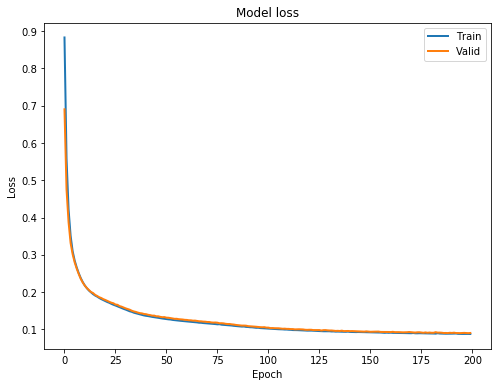

In [21]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

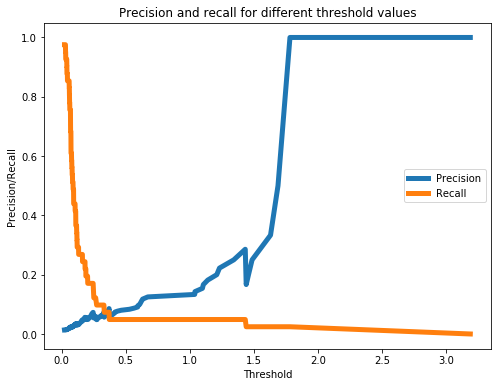

In [22]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

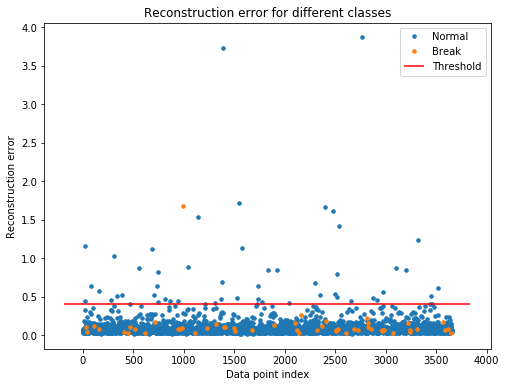

In [23]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

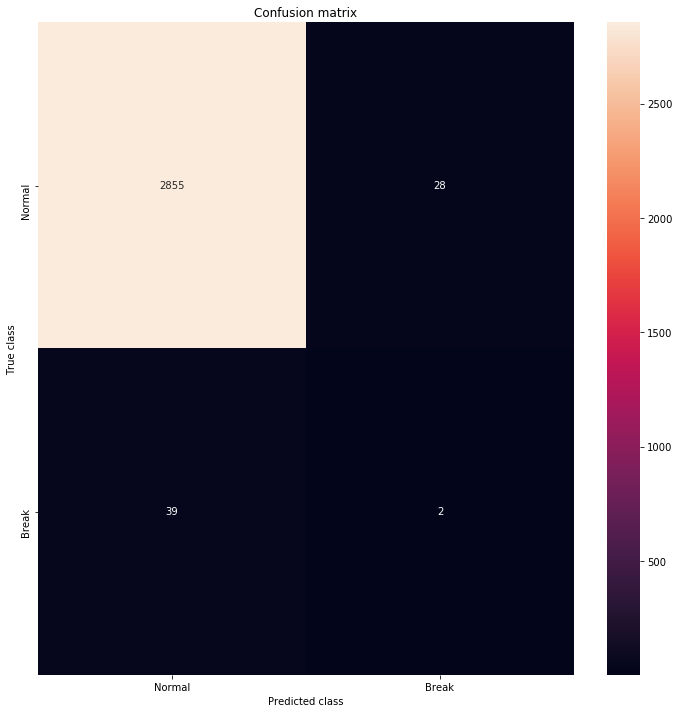

In [24]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

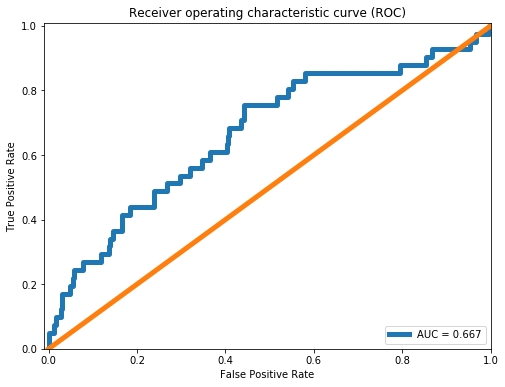

In [25]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()